# Predict carbonate content from ODP cores

## Goal & Objectives
Train an algorithm based on this modest dataset to be able to predict carbonate content at a much higher resolution using either one or several of the other features (gamma ray, colour, density) because these were measured automatically using a core track system.


1. To explore, select the features and prepare the data for the machine learning training using data from the 'data_for_training.csv' file. 
2. To explore different machine learning algorithms, train them in order to predict carbonate content, and select the most performant one 
3. Using  data from the 'all_data.csv' file, to 
**(a)** apply trained algorithm in order to create a new column in your all_data dataframe that contains the predicted carbonate content and 

**(b)** plot a nice graph of carbonate content (horizontal) versus depth (vertical, increasing towards the bottom) for Site 1195, hole A, between 110 and 130 mbsf.


## The Data

* **'data_for_training.csv'**: contains both the feature data and the data to build a predictor for: carbonate content. This has just over 600 datapoints.

* **'all_data.csv'**: This is a much larger file that contains all of the data from multiple wells (>27k datapoints) but does NOT contain the carbonate content. 

Note that the data has already been pre-prepared, i.e. it is clean, there are no 'NaN', and the different types of data are all already occuring on the same row (so you won't have to do any data wrangling).


#### Sample information (in both files)

- **'label'**: A long label for the sample, created for you already and taking the leg, site, hole, core, cutting shoe and top information into consideration.
- **'Leg'**: The 'Leg' number, which is the old ODP (the predecessor of IODP) terminology for an 'Expedition'
- **'Site'**: The ODP Site number, where multiple wells can be drilled
- **'H'**: The 'Hole' name (a sequential letter starting with A, B, C, ...), effectively a well. So a full well name would be 'leg-siteHole', such as 'ODP 194-1192A' 
- **'Cor'**: The core number, each core is drilled for about 9.8 meters down from the surface of the sediments. Thus, core 1 is the shallowest core, and core numbers increase downhole.
- **'T'**: The tool used to cut the core, i.e. the cutting shoe. This can be one of 6 types: H, X, R, Z, M and W. H and X are the most common.
- **'Sc'**: The section of the core the sample comes from. Each core is divided into up to 7 sections and one core catcher ('CC').
- **'Top(cm)'**: The distance in cm from the top of the section where the sample was collected.
- **'Depth (mbsf)'**: The depth of the sample in the well measured from the seafloor (mbsf = meters below seafloor).

#### High-resolution core measurement track data (in both files)
This data is potentially useful for training an algorithm. It is present both in the data for training and in the general data file:
- **'Corr. Counts'**: The 'Corrected counts' for the core natural gamma ray. In effect, natural gamma ray data.
- **'Density (g/cc)'**: An estimate of the bulk density of the core from automated core measurements.
- **'L*'**: The luminosity channel, part of the Lab* color space of the sediment color measured by the automated tracks. 
- **'a*'**: The 'a' color axis, part of the Lab* color space of the sediment color measured by the automated tracks.
- **'b*'**: The 'b' color axis, part of the Lab* color space of the sediment color measured by the automated tracks.

#### Labelled data (only in data_for_training.csv)
The 'data_for_training.csv' file contains all of the above, plus the label data that you need to predict, i.e. the percentage of carbonate.
- **'CaCO3 (wt %)'**: percent carbonate present in the sample. This is the 'label', or in other words the quantity you need to predict with your trained algorithm.


In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:

raw_dataset= pd.read_csv('data/data_for_training.csv')
raw_dataset

,Leg,Site,H,Cor,T,Sc,Top(cm),Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*
0,189,1170,D,31,R,3,72,706.52,0.650,6.59,1.763,28.06,0.90,3.24
1,189,1170,D,32,R,1,72,713.12,0.790,6.39,1.739,24.80,0.79,5.95
2,189,1170,D,32,R,5,72,719.12,0.760,6.79,1.720,29.54,0.04,4.54
3,189,1170,D,33,R,3,72,725.72,0.950,7.39,1.808,30.83,0.87,2.64
4,189,1170,D,34,R,3,72,735.32,8.190,6.39,1.723,34.92,0.08,5.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,210,1276,A,97,R,1,96,1701.46,0.167,42.28,1.805,41.31,-0.11,0.32
611,210,1276,A,97,R,2,0,1702.00,5.998,10.08,-0.258,40.52,-0.10,0.71
612,210,1276,A,98,R,3,0,1713.01,1.250,27.48,1.927,56.16,0.80,5.13
613,210,1276,A,98,R,3,45,1713.46,8.163,31.48,1.249,48.67,2.24,6.44


# Data Exploration

In [4]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Leg             615 non-null    int64  
 1   Site            615 non-null    int64  
 2   H               615 non-null    object 
 3   Cor             615 non-null    int64  
 4   T               615 non-null    object 
 5   Sc              615 non-null    object 
 6   Top(cm)         615 non-null    int64  
 7   Depth (mbsf)    615 non-null    float64
 8   CaCO3 (wt %)    615 non-null    float64
 9   Corr. Counts    615 non-null    float64
 10  Density (g/cc)  615 non-null    float64
 11  L*              615 non-null    float64
 12  a*              615 non-null    float64
 13  b*              615 non-null    float64
dtypes: float64(7), int64(4), object(3)
memory usage: 67.4+ KB


In [5]:
raw_dataset.describe()

,Leg,Site,Cor,Top(cm),Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000
mean,196.200000,1206.417886,35.383740,59.195122,469.554033,70.406533,17.331171,1.702659,49.276211,-0.319577,7.444764
std,5.682478,28.710098,28.571114,27.358954,511.135556,31.131952,12.770442,0.494601,9.548975,1.016405,3.937764
min,189.000000,1170.000000,1.000000,0.000000,2.200000,0.083000,6.090000,-0.382000,20.920000,-2.980000,0.000000
25%,194.000000,1194.000000,11.000000,47.000000,130.130000,66.471500,9.590000,1.706000,43.430000,-0.970000,5.225000
50%,194.000000,1195.000000,28.000000,64.000000,317.140000,82.120000,12.690000,1.824000,51.270000,-0.430000,7.980000
75%,194.000000,1198.000000,49.000000,74.000000,495.205000,90.070000,17.490000,1.932500,55.400000,0.040000,9.975000
max,210.000000,1276.000000,98.000000,143.000000,1713.880000,106.890000,72.780000,2.311000,76.860000,6.960000,28.980000


In [6]:
raw_dataset.columns

Index(['Leg', 'Site', 'H', 'Cor', 'T', 'Sc', 'Top(cm)', 'Depth (mbsf)',
       'CaCO3 (wt %)', 'Corr. Counts', 'Density (g/cc)', 'L*', 'a*', 'b*'],
      dtype='object')

In [7]:
raw_dataset.isna().sum()

Leg               0
Site              0
H                 0
Cor               0
T                 0
Sc                0
Top(cm)           0
Depth (mbsf)      0
CaCO3 (wt %)      0
Corr. Counts      0
Density (g/cc)    0
L*                0
a*                0
b*                0
dtype: int64

# Data Transformation

## Create index

In [8]:
raw_dataset['label'] = raw_dataset['Leg'].astype(str) + '-' + \
                        raw_dataset['Site'].astype(str) + raw_dataset['H'].astype(str) + '-' + \
                            [f'{core:03d}' for core in raw_dataset['Cor']] + raw_dataset['T'].astype(str) + '-' + \
                            raw_dataset['Sc'].astype(str) + '-' + (raw_dataset['Top(cm)']/100).astype(str)
raw_dataset['label']

0      189-1170D-031R-3-0.72
1      189-1170D-032R-1-0.72
2      189-1170D-032R-5-0.72
3      189-1170D-033R-3-0.72
4      189-1170D-034R-3-0.72
               ...          
610    210-1276A-097R-1-0.96
611     210-1276A-097R-2-0.0
612     210-1276A-098R-3-0.0
613    210-1276A-098R-3-0.45
614    210-1276A-098R-3-0.87
Name: label, Length: 615, dtype: object

In [9]:
raw_dataset.index= raw_dataset['label']
raw_dataset

,Leg,Site,H,Cor,T,Sc,Top(cm),Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*,label
label,,,,,,,,,,,,,,,
189-1170D-031R-3-0.72,189,1170,D,31,R,3,72,706.52,0.650,6.59,1.763,28.06,0.90,3.24,189-1170D-031R-3-0.72
189-1170D-032R-1-0.72,189,1170,D,32,R,1,72,713.12,0.790,6.39,1.739,24.80,0.79,5.95,189-1170D-032R-1-0.72
189-1170D-032R-5-0.72,189,1170,D,32,R,5,72,719.12,0.760,6.79,1.720,29.54,0.04,4.54,189-1170D-032R-5-0.72
189-1170D-033R-3-0.72,189,1170,D,33,R,3,72,725.72,0.950,7.39,1.808,30.83,0.87,2.64,189-1170D-033R-3-0.72
189-1170D-034R-3-0.72,189,1170,D,34,R,3,72,735.32,8.190,6.39,1.723,34.92,0.08,5.05,189-1170D-034R-3-0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210-1276A-097R-1-0.96,210,1276,A,97,R,1,96,1701.46,0.167,42.28,1.805,41.31,-0.11,0.32,210-1276A-097R-1-0.96
210-1276A-097R-2-0.0,210,1276,A,97,R,2,0,1702.00,5.998,10.08,-0.258,40.52,-0.10,0.71,210-1276A-097R-2-0.0
210-1276A-098R-3-0.0,210,1276,A,98,R,3,0,1713.01,1.250,27.48,1.927,56.16,0.80,5.13,210-1276A-098R-3-0.0


In [10]:
raw_dataset= raw_dataset.drop('label', axis=1)
raw_dataset

,Leg,Site,H,Cor,T,Sc,Top(cm),Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*
label,,,,,,,,,,,,,,
189-1170D-031R-3-0.72,189,1170,D,31,R,3,72,706.52,0.650,6.59,1.763,28.06,0.90,3.24
189-1170D-032R-1-0.72,189,1170,D,32,R,1,72,713.12,0.790,6.39,1.739,24.80,0.79,5.95
189-1170D-032R-5-0.72,189,1170,D,32,R,5,72,719.12,0.760,6.79,1.720,29.54,0.04,4.54
189-1170D-033R-3-0.72,189,1170,D,33,R,3,72,725.72,0.950,7.39,1.808,30.83,0.87,2.64
189-1170D-034R-3-0.72,189,1170,D,34,R,3,72,735.32,8.190,6.39,1.723,34.92,0.08,5.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210-1276A-097R-1-0.96,210,1276,A,97,R,1,96,1701.46,0.167,42.28,1.805,41.31,-0.11,0.32
210-1276A-097R-2-0.0,210,1276,A,97,R,2,0,1702.00,5.998,10.08,-0.258,40.52,-0.10,0.71
210-1276A-098R-3-0.0,210,1276,A,98,R,3,0,1713.01,1.250,27.48,1.927,56.16,0.80,5.13


In [11]:
raw_dataset = raw_dataset.sort_values(by = ['label', 'Depth (mbsf)'], ascending = [True, True])
raw_dataset

,Leg,Site,H,Cor,T,Sc,Top(cm),Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*
label,,,,,,,,,,,,,,
189-1170D-031R-3-0.72,189,1170,D,31,R,3,72,706.52,0.650,6.59,1.763,28.06,0.90,3.24
189-1170D-032R-1-0.72,189,1170,D,32,R,1,72,713.12,0.790,6.39,1.739,24.80,0.79,5.95
189-1170D-032R-5-0.72,189,1170,D,32,R,5,72,719.12,0.760,6.79,1.720,29.54,0.04,4.54
189-1170D-033R-3-0.72,189,1170,D,33,R,3,72,725.72,0.950,7.39,1.808,30.83,0.87,2.64
189-1170D-034R-3-0.72,189,1170,D,34,R,3,72,735.32,8.190,6.39,1.723,34.92,0.08,5.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210-1276A-097R-1-0.96,210,1276,A,97,R,1,96,1701.46,0.167,42.28,1.805,41.31,-0.11,0.32
210-1276A-097R-2-0.0,210,1276,A,97,R,2,0,1702.00,5.998,10.08,-0.258,40.52,-0.10,0.71
210-1276A-098R-3-0.0,210,1276,A,98,R,3,0,1713.01,1.250,27.48,1.927,56.16,0.80,5.13


## remove columns not needed for training model

In [12]:
raw_dataset = raw_dataset.drop(['Leg' ,'Cor','Top(cm)','Site','Sc', 'H', 'T'],axis=1).copy()
raw_dataset

,Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*
label,,,,,,,
189-1170D-031R-3-0.72,706.52,0.650,6.59,1.763,28.06,0.90,3.24
189-1170D-032R-1-0.72,713.12,0.790,6.39,1.739,24.80,0.79,5.95
189-1170D-032R-5-0.72,719.12,0.760,6.79,1.720,29.54,0.04,4.54
189-1170D-033R-3-0.72,725.72,0.950,7.39,1.808,30.83,0.87,2.64
189-1170D-034R-3-0.72,735.32,8.190,6.39,1.723,34.92,0.08,5.05
...,...,...,...,...,...,...,...
210-1276A-097R-1-0.96,1701.46,0.167,42.28,1.805,41.31,-0.11,0.32
210-1276A-097R-2-0.0,1702.00,5.998,10.08,-0.258,40.52,-0.10,0.71
210-1276A-098R-3-0.0,1713.01,1.250,27.48,1.927,56.16,0.80,5.13


In [13]:
corr_matrix = raw_dataset.corr()
corr_matrix

,Depth (mbsf),CaCO3 (wt %),Corr. Counts,Density (g/cc),L*,a*,b*
Depth (mbsf),1.000000,-0.834301,0.769107,0.093203,-0.635275,0.031470,-0.745485
CaCO3 (wt %),-0.834301,1.000000,-0.720893,-0.199953,0.648910,0.066056,0.705976
Corr. Counts,0.769107,-0.720893,1.000000,0.144660,-0.508886,0.027629,-0.566446
Density (g/cc),0.093203,-0.199953,0.144660,1.000000,0.145023,0.031600,0.026738
L*,-0.635275,0.648910,-0.508886,0.145023,1.000000,0.044501,0.750659
a*,0.031470,0.066056,0.027629,0.031600,0.044501,1.000000,0.296762
b*,-0.745485,0.705976,-0.566446,0.026738,0.750659,0.296762,1.000000


# data Visualisation

<Axes: >

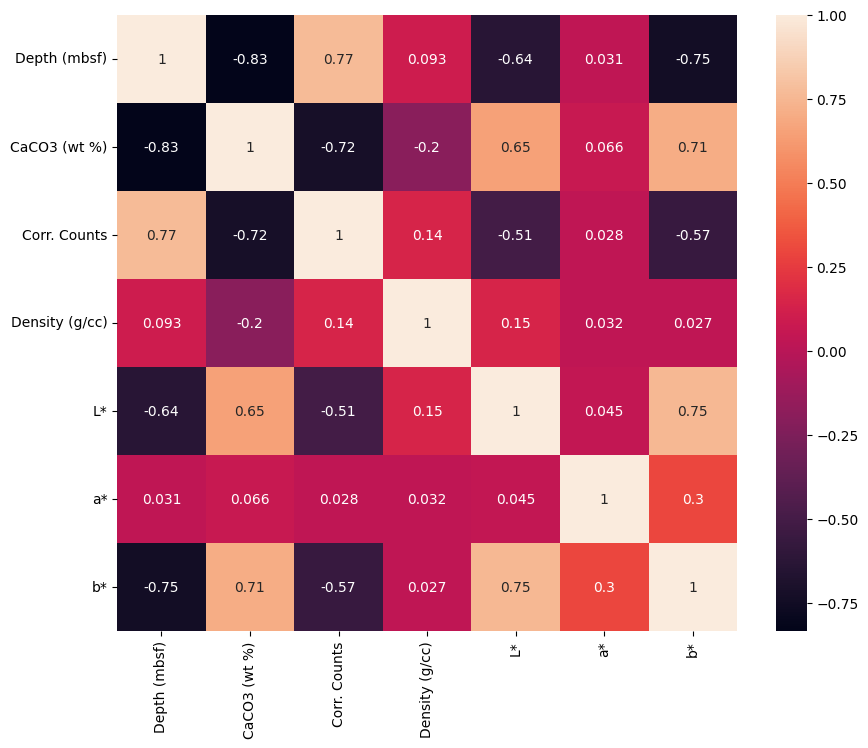

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2g')

Target `CaCO3`:
* has strong negative correlation with depth and corr.count
* Strong positive correlation with L* and b*
* Weak correlation with  a* and Density
 

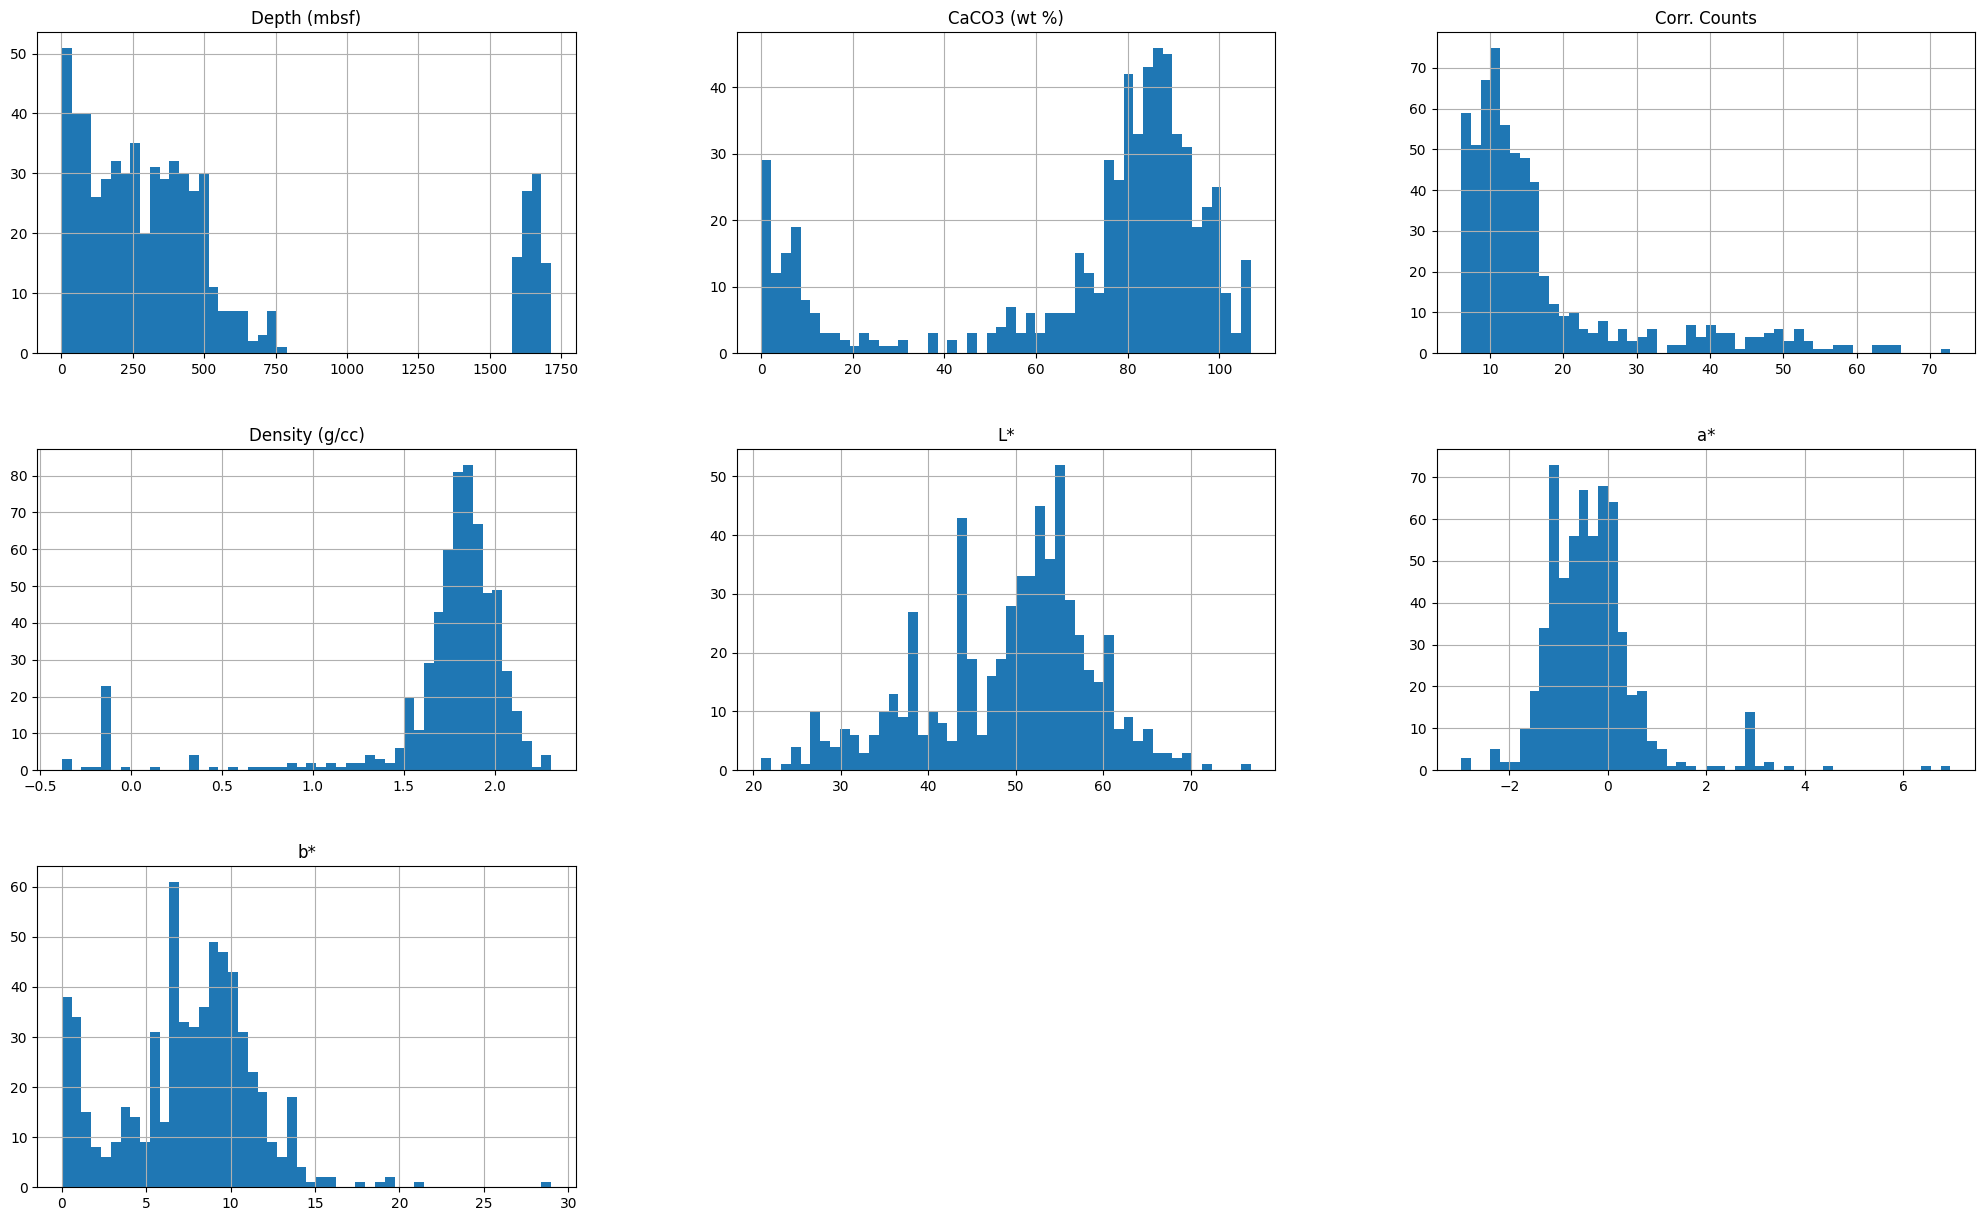

In [15]:
raw_dataset.hist(bins=50, figsize=(25,15))
plt.show()

From the above histogram plot there seems to be missing data from the depth column at about `750 - 1600(bsf)`

The Target column CaCo3 has a bimodal distribution


# Pre-processing

## Split  data train and test sets

In [84]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(raw_dataset, test_size=0.2, random_state=42)

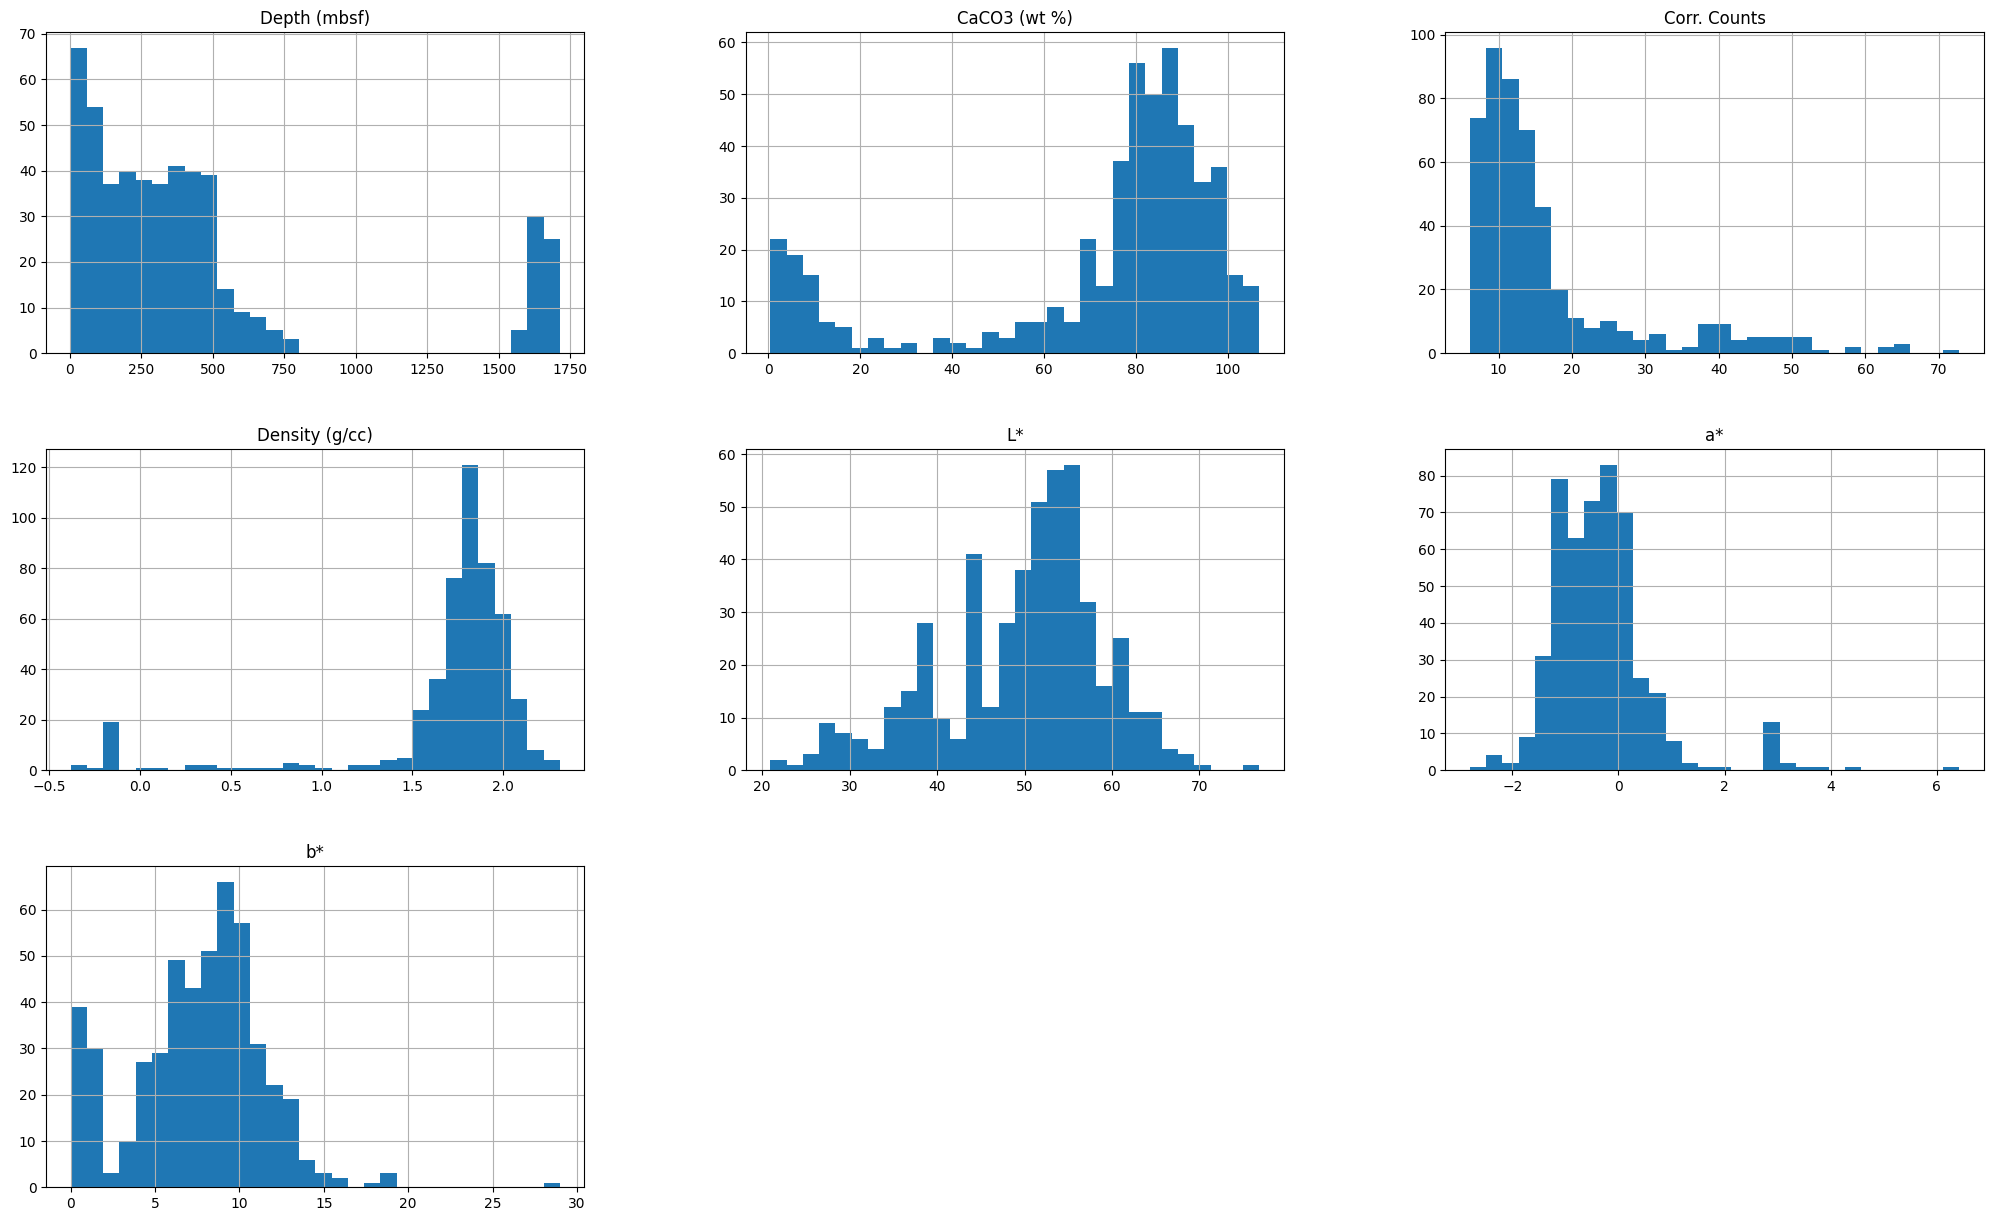

In [85]:
train_set.hist(bins=30, figsize=(25,15));

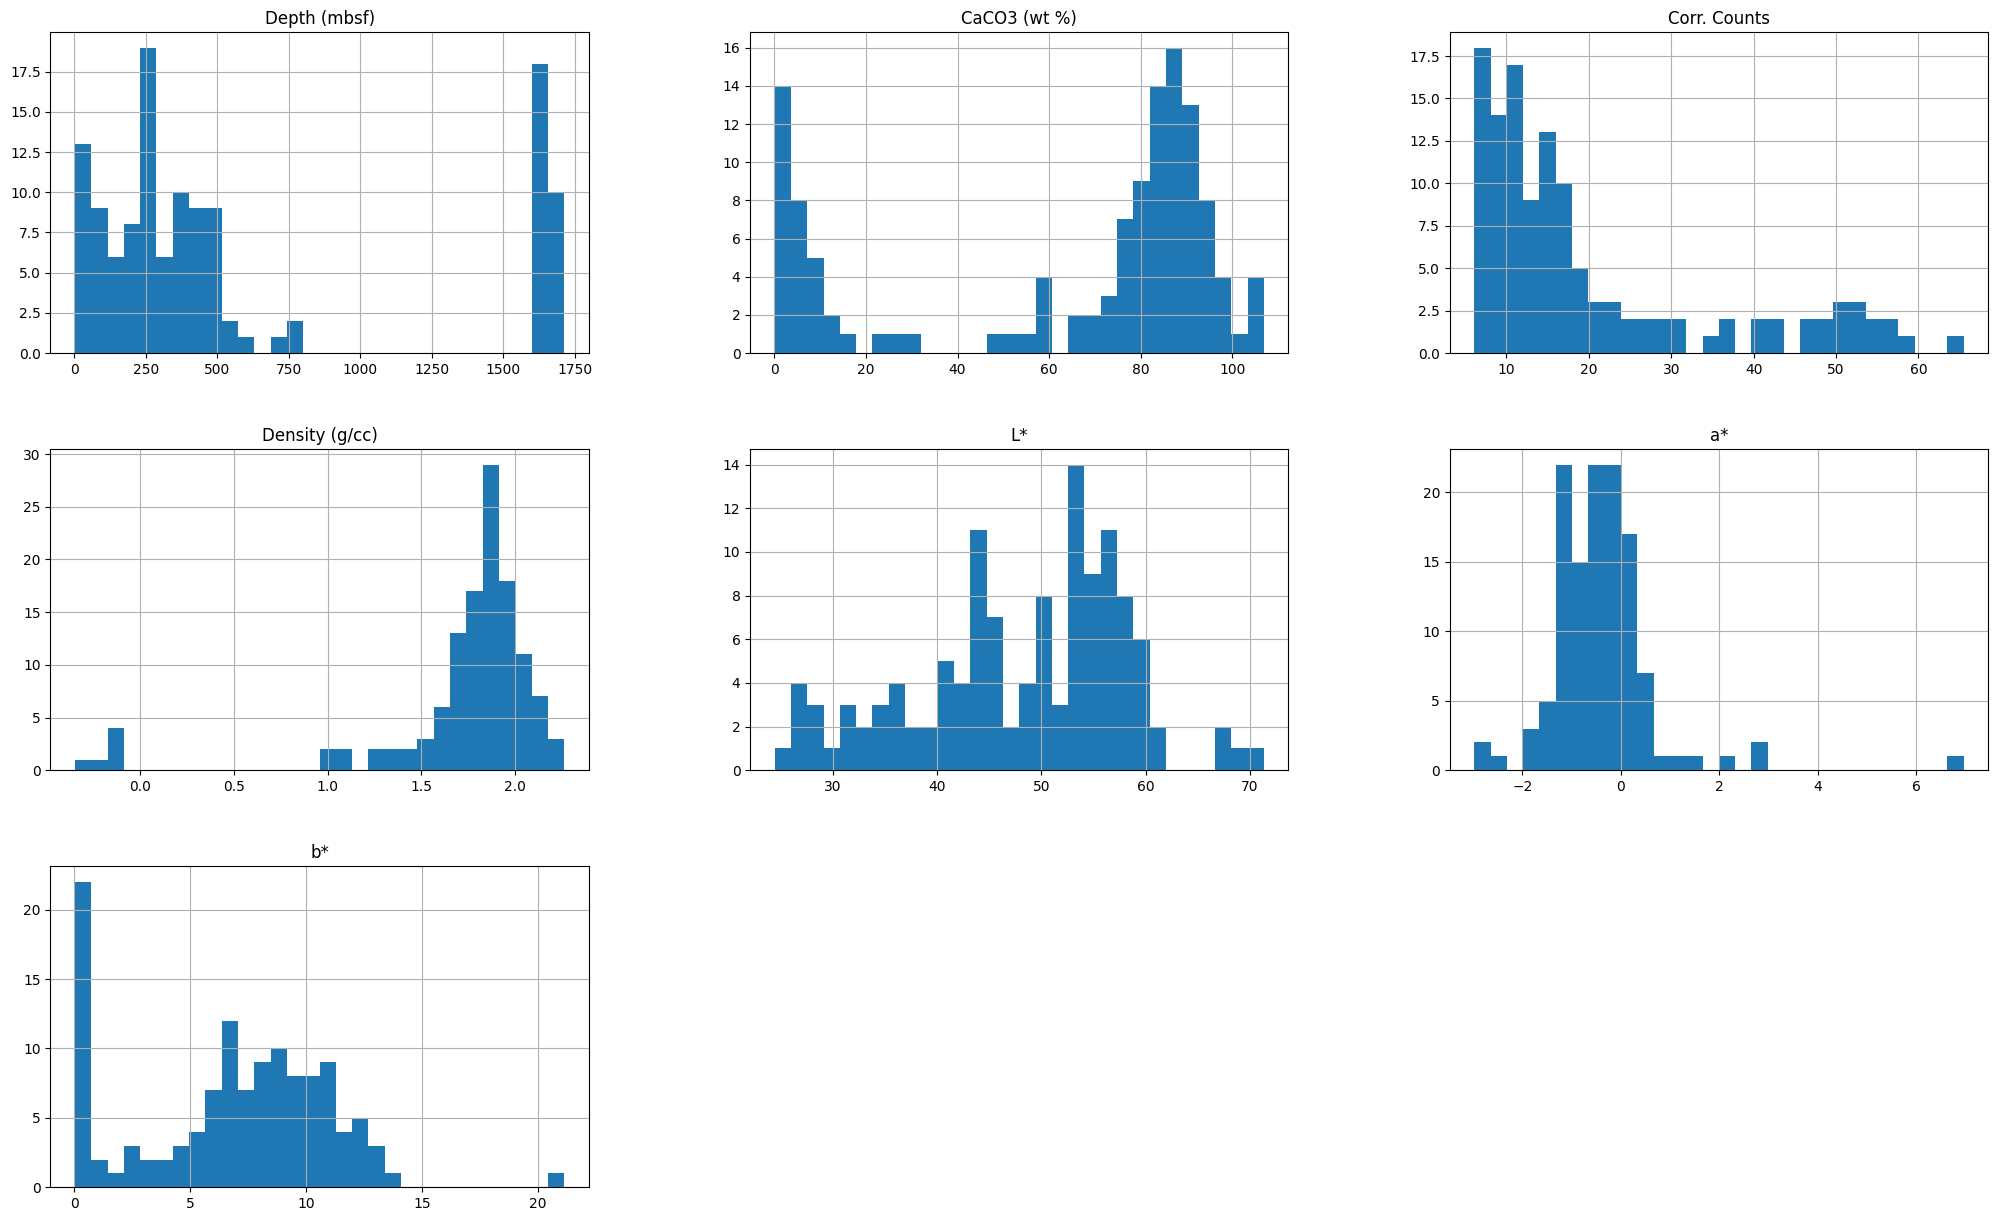

In [86]:
test_set.hist(bins=30, figsize=(25,15));

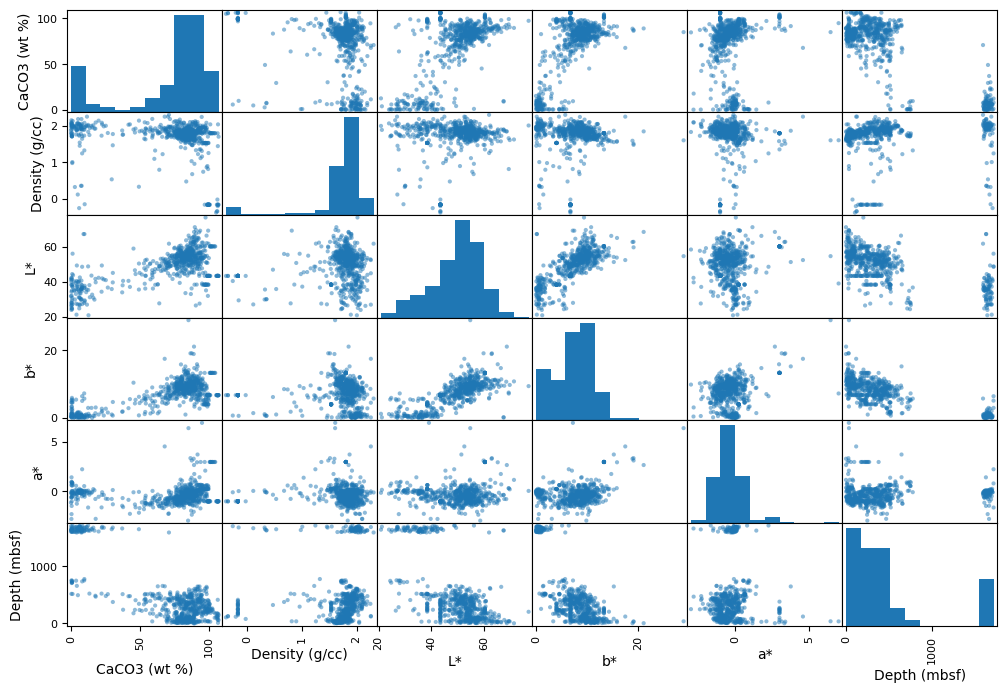

In [87]:
from pandas.plotting import scatter_matrix

attributes = ["CaCO3 (wt %)", "Density (g/cc)","L*", "b*","a*","Depth (mbsf)"]
scatter_matrix(raw_dataset[attributes], figsize=(12, 8));

In [88]:
train_data = train_set.drop(["CaCO3 (wt %)"], axis=1) 
train_label= train_set["CaCO3 (wt %)"].copy()

In [89]:
test_data = test_set.drop(["CaCO3 (wt %)"], axis=1) 
test_label = test_set["CaCO3 (wt %)"].copy()

In [90]:
# The I create a function that will add two columns to my dataframe: the angle and distance of the polar coordinates
ngr_ix, depth_ix, a_ix, b_ix, L_ix = [
    list(train_data.columns).index(col)
    for col in ("Corr. Counts", "Depth (mbsf)", "a*", "b*", "L*")]


def add_polar_colors(data):
    color_angle = np.arctan(data[:,b_ix] / (data[:,a_ix]+1E-5))
    color_distance = data[:,a_ix]/np.cos(color_angle)
    return np.c_[data, color_angle, color_distance]

In [91]:
train_data

,Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*
label,,,,,,
194-1193A-050X-1-0.5,282.40,7.29,1.921,48.18,-0.18,7.94
194-1193A-055X-CC-0.17,320.57,14.49,1.936,55.95,0.13,9.99
194-1195A-009H-5-0.64,76.76,22.29,1.714,58.77,0.29,13.71
194-1198B-027R-2-0.72,447.88,14.29,1.876,51.07,-0.80,7.18
194-1196A-028R-1-0.08,258.88,7.69,-0.164,43.43,-1.02,6.76
...,...,...,...,...,...,...
194-1193A-045X-1-0.38,239.18,14.49,1.768,40.61,-1.61,4.48
194-1193A-062X-5-0.74,385.07,18.09,2.195,53.69,-0.37,6.92
194-1195B-035X-3-0.6,326.70,16.49,2.180,52.62,-0.87,9.54


In [92]:
from sklearn.preprocessing import FunctionTransformer

attr_adder = FunctionTransformer(add_polar_colors)


data_extra_attribs = attr_adder.fit_transform(train_data.values)


data_extra_attribs = pd.DataFrame(
    data_extra_attribs,
    columns=list(train_data.columns)+["color_angle", "color_distance"],
    index=train_data.index)
data_extra_attribs

,Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*,color_angle,color_distance
label,,,,,,,,
194-1193A-050X-1-0.5,282.40,7.29,1.921,48.18,-0.18,7.94,-1.548131,-7.942481
194-1193A-055X-CC-0.17,320.57,14.49,1.936,55.95,0.13,9.99,1.557783,9.990077
194-1195A-009H-5-0.64,76.76,22.29,1.714,58.77,0.29,13.71,1.549646,13.712594
194-1198B-027R-2-0.72,447.88,14.29,1.876,51.07,-0.80,7.18,-1.459835,-7.224520
194-1196A-028R-1-0.08,258.88,7.69,-0.164,43.43,-1.02,6.76,-1.421040,-6.836585
...,...,...,...,...,...,...,...,...
194-1193A-045X-1-0.38,239.18,14.49,1.768,40.61,-1.61,4.48,-1.225796,-4.760541
194-1193A-062X-5-0.74,385.07,18.09,2.195,53.69,-0.37,6.92,-1.517380,-6.930071
194-1195B-035X-3-0.6,326.70,16.49,2.180,52.62,-0.87,9.54,-1.479854,-9.579697


In [93]:
test_data.shape

(123, 6)

## pipeline

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

my_pipeline = Pipeline([
         ('attribs_adder', FunctionTransformer(add_polar_colors)),
         ('minmax_scaler', MinMaxScaler())
     ])



In [95]:
from sklearn.preprocessing import FunctionTransformer

train_data = my_pipeline.fit_transform(train_data.values)
train_data

array([[0.16369882, 0.0179937 , 0.8551801 , ..., 0.27398206, 0.00657596,
        0.145225  ],
       [0.18599855, 0.12595592, 0.86075009, ..., 0.3447205 , 0.99585536,
        0.55262134],
       [0.04355954, 0.24291498, 0.77831415, ..., 0.47308489, 0.99326369,
        0.6371904 ],
       ...,
       [0.18957983, 0.15594542, 0.95135537, ..., 0.32919255, 0.02832334,
        0.10803033],
       [0.03968031, 0.09296746, 0.79985147, ..., 0.32781228, 0.03937801,
        0.10812413],
       [0.21617943, 0.10196431, 0.79093947, ..., 0.23706004, 0.05083027,
        0.16752805]])

In [96]:
def set_pipeline(regressor):
    my_pipeline = Pipeline([
        ('attribs_adder', FunctionTransformer(add_polar_colors)),
        ('scaler', MinMaxScaler()),
        ('regressor', regressor),
    ])
    return my_pipeline

In [97]:
train_data.shape
train_data

array([[0.16369882, 0.0179937 , 0.8551801 , ..., 0.27398206, 0.00657596,
        0.145225  ],
       [0.18599855, 0.12595592, 0.86075009, ..., 0.3447205 , 0.99585536,
        0.55262134],
       [0.04355954, 0.24291498, 0.77831415, ..., 0.47308489, 0.99326369,
        0.6371904 ],
       ...,
       [0.18957983, 0.15594542, 0.95135537, ..., 0.32919255, 0.02832334,
        0.10803033],
       [0.03968031, 0.09296746, 0.79985147, ..., 0.32781228, 0.03937801,
        0.10812413],
       [0.21617943, 0.10196431, 0.79093947, ..., 0.23706004, 0.05083027,
        0.16752805]])

In [98]:
test_data

,Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*
label,,,,,,
194-1195B-020H-5-0.64,186.04,9.09,1.791,59.97,-0.54,10.58
194-1197B-039R-6-0.9,423.36,11.09,1.906,49.35,-0.04,11.05
194-1198A-007H-6-0.62,60.62,9.09,1.868,67.65,-0.78,9.54
210-1276A-097R-1-0.96,1701.46,42.28,1.805,41.31,-0.11,0.32
194-1194A-003H-2-0.7,16.40,7.89,1.771,54.16,-0.92,13.72
...,...,...,...,...,...,...
194-1195B-041X-1-0.64,381.54,8.69,1.896,52.74,-1.23,7.80
194-1195B-046X-1-0.64,429.74,11.49,2.061,54.39,-1.39,7.92
194-1195B-022H-1-0.64,199.04,7.09,1.643,50.43,-0.30,6.95


In [99]:
test_data = my_pipeline.fit_transform(test_data.values)

# training Model

## LinearRegression

In [100]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()


lin_reg.fit(train_data, train_label)


lin_reg.intercept_, lin_reg.coef_

(82.43268642355264,
 array([-50.6742709 , -29.90399008, -29.69559398,  45.22730957,
         30.72417056,   3.70873599,   2.67532847, -11.15973082]))

In [101]:
Y_pred = lin_reg.predict(test_data) #Y_pred is the CaCO3 (wt%) predicted using linear regression
Y_pred

array([ 93.85151336,  75.99917041, 102.87091852,  10.61138012,
        94.49969787,  -3.06081423,  81.0379464 ,  49.23242023,
        74.30134471,  82.88728892,  68.35863219,  98.25221929,
        57.69150664,  76.31182299,  85.2421156 ,  73.49349352,
        79.25050471,  77.13852622,  87.24172284,  10.00773915,
        98.57398136,  80.94441305,  -3.23708022,  70.13915072,
         5.58688702,  60.99695003,  83.7167608 , 112.11527563,
        85.36684634,  49.6027241 ,  59.26712646,  95.59297145,
        69.69802026,  64.25200995,  87.87284057,  91.83699263,
        85.56230837, -15.21313854,  85.86156457,  69.75441611,
        57.38056983,  71.03477581,  81.59653515,  63.24487717,
        84.91440344,  25.76289431,  89.93237704, -13.94865205,
        87.30351338,  -2.52194297,  60.47079695,  86.59954329,
        87.41924245,   1.99575947,  70.91769647,  84.92714871,
        81.45176813,  77.54827127,  11.77731353,  15.46958489,
        -7.38822258,  94.99427824,  98.39912741,   8.65

In [102]:
test_data.shape, Y_pred.shape

((123, 8), (123,))

In [103]:
comp = pd.DataFrame({'Actual score': test_label,
                    'Predictions': Y_pred})
comp['differnce']= comp['Predictions']-comp['Actual score']
comp

,Actual score,Predictions,differnce
label,,,
194-1195B-020H-5-0.64,85.020,93.851513,8.831513
194-1197B-039R-6-0.9,92.000,75.999170,-16.000830
194-1198A-007H-6-0.62,90.570,102.870919,12.300919
210-1276A-097R-1-0.96,0.167,10.611380,10.444380
194-1194A-003H-2-0.7,81.800,94.499698,12.699698
...,...,...,...
194-1195B-041X-1-0.64,54.890,76.705740,21.815740
194-1195B-046X-1-0.64,76.900,73.167575,-3.732425
194-1195B-022H-1-0.64,89.940,85.899544,-4.040456


In [104]:
test_data.shape

(123, 8)

In [105]:
lin_regscore=lin_reg.score(test_data, test_label)
lin_regscore

0.8265649383719116

In [106]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(test_label, Y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

14.952198767910183

In [107]:
# from sklearn.preprocessing import PolynomialFeatures

# poly_features = PolynomialFeatures(degree=2, include_bias=False)
# X_poly = poly_features.fit_transform(train_data)
# lin_reg = LinearRegression()

# lin_reg.fit(X_poly, train_label)
# lin_reg.intercept_, lin_reg.coef_

## Random Forest Regressor

In [108]:
from sklearn.ensemble import RandomForestRegressor


rfr= RandomForestRegressor()
rfr.fit(train_data, train_label)

RandomForestRegressor()

In [109]:
test_data.shape

(123, 8)

In [110]:
rfr_score =rfr.score(test_data, test_label)
rfr_score

0.9133718487031669

In [111]:
#test_label= test_label.reshape(-1,1)

pred_label = rfr.predict(test_data)

## Ridge regression

In [119]:
from sklearn import linear_model
ridge = linear_model.Ridge()
ridge.fit(train_data, train_label)
ridge_score= ridge.score(test_data, test_label)
ridge_score

0.8274679719907541

## Decision tree regression

In [117]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(train_data, train_label)
dtr_score= dtr.score(test_data, test_label)
dtr_score

0.8440917414192872

## Support vector regression (SVR)

In [116]:
from sklearn import svm
svm = svm.SVR()
svm.fit(train_data, train_label)
svm_score= svm.score(test_data, test_label)
svm_score

0.6005084825292442

# Evaluate Models

In [122]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x: 'float | ArrayLike', height: 'float | ArrayLike', width: 'float | ArrayLike' = 0.8, bottom: 'float | ArrayLike | None' = None, *, align: "Literal['center', 'edge']" = 'center', data=None, **kwargs) -> 'BarContainer'
    Make a bar plot.

    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *height* and *width*. The vertical baseline
    is *bottom* (default 0).

    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.

    Parameters
    ----------
    x : float or array-like
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.

    height : float or array-like
        The height(s) of the bars.

        Note that if *bottom* has units (e.g. datetime), *height* should be in
        units that are a difference from the value of *bottom* (e.g. timedelta).

    width

<BarContainer object of 5 artists>

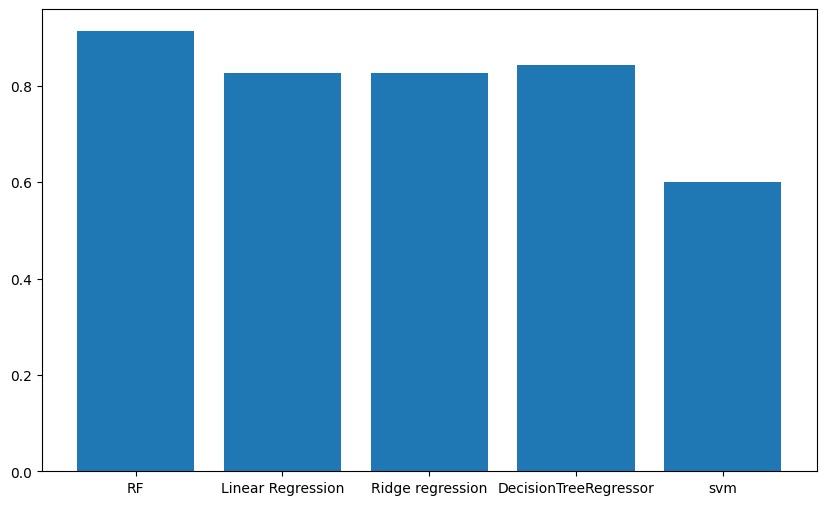

In [123]:
compare_scores={'RF': rfr_score,
              'Linear Regression': lin_regscore,
              'Ridge regression': ridge_score,
              'DecisionTreeRegressor': dtr_score,
              'svm': svm_score
              }
plt.figure(figsize=(10, 6))
plt.bar(compare_scores.keys(), compare_scores.values(), )

In [ ]:
diff= pred_label-test_label
comp.index= test_set['Depth (mbsf)']


comp= pd.DataFrame({'Actual': test_label,
             'RF': pred_label,
              'LR': Y_pred,
              })
comp.index= test_set.index

comp

,Actual,RF,LR,Depth
Depth (mbsf),,,,
186.04,85.020,90.38060,93.851513,186.04
423.36,92.000,83.71480,75.999170,423.36
60.62,90.570,89.85090,102.870919,60.62
1701.46,0.167,10.76065,10.611380,1701.46
16.40,81.800,81.79420,94.499698,16.40
...,...,...,...,...
381.54,54.890,77.61956,76.705740,381.54
429.74,76.900,78.66576,73.167575,429.74
199.04,89.940,86.08570,85.899544,199.04


# Predictions

In [133]:
all_data = pd.read_csv('data/all_data.csv')
all_data

,label,Leg,Site,H,Cor,T,Sc,Top(cm),Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*
0,189-1168A-001H-1-0.2,189,1168,A,1,H,1,20.0,0.200,0.99,1.556,56.71,-1.00,8.92
1,189-1168A-001H-1-0.5,189,1168,A,1,H,1,50.0,0.500,0.39,1.547,54.47,-0.89,9.93
2,189-1168A-001H-1-0.7,189,1168,A,1,H,1,70.0,0.700,1.39,1.402,58.19,-0.48,6.75
3,189-1168A-001H-1-0.9,189,1168,A,1,H,1,90.0,0.900,1.39,1.736,62.45,-1.06,7.53
4,189-1168A-001H-1-1.1,189,1168,A,1,H,1,110.0,1.100,0.99,1.685,61.38,-1.55,8.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27041,210-1276A-099R-5-0.45,210,1276,A,99,R,5,45.0,1724.410,13.68,2.212,31.76,-0.85,0.33
27042,210-1276A-099R-5-0.775,210,1276,A,99,R,5,77.5,1724.735,15.08,2.374,32.84,-0.63,0.08
27043,210-1276A-099R-5-0.8,210,1276,A,99,R,5,80.0,1724.760,15.28,2.426,33.54,-0.65,0.01
27044,210-1276A-099R-5-1.075,210,1276,A,99,R,5,107.5,1725.035,12.88,2.227,33.01,-0.51,0.21


In [134]:
all_data= all_data.drop(['Leg' ,'Cor','Top(cm)','Site','Sc', 'H', 'T'],axis=1).copy()
all_data

,label,Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*
0,189-1168A-001H-1-0.2,0.200,0.99,1.556,56.71,-1.00,8.92
1,189-1168A-001H-1-0.5,0.500,0.39,1.547,54.47,-0.89,9.93
2,189-1168A-001H-1-0.7,0.700,1.39,1.402,58.19,-0.48,6.75
3,189-1168A-001H-1-0.9,0.900,1.39,1.736,62.45,-1.06,7.53
4,189-1168A-001H-1-1.1,1.100,0.99,1.685,61.38,-1.55,8.52
...,...,...,...,...,...,...,...
27041,210-1276A-099R-5-0.45,1724.410,13.68,2.212,31.76,-0.85,0.33
27042,210-1276A-099R-5-0.775,1724.735,15.08,2.374,32.84,-0.63,0.08
27043,210-1276A-099R-5-0.8,1724.760,15.28,2.426,33.54,-0.65,0.01
27044,210-1276A-099R-5-1.075,1725.035,12.88,2.227,33.01,-0.51,0.21


In [135]:
all_data.index= all_data['label']
all_data= all_data.drop(['label'], axis=1)
all_data=all_data.dropna()
all_data

,Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*
label,,,,,,
189-1168A-001H-1-0.2,0.200,0.99,1.556,56.71,-1.00,8.92
189-1168A-001H-1-0.5,0.500,0.39,1.547,54.47,-0.89,9.93
189-1168A-001H-1-0.7,0.700,1.39,1.402,58.19,-0.48,6.75
189-1168A-001H-1-0.9,0.900,1.39,1.736,62.45,-1.06,7.53
189-1168A-001H-1-1.1,1.100,0.99,1.685,61.38,-1.55,8.52
...,...,...,...,...,...,...
210-1276A-099R-5-0.45,1724.410,13.68,2.212,31.76,-0.85,0.33
210-1276A-099R-5-0.775,1724.735,15.08,2.374,32.84,-0.63,0.08
210-1276A-099R-5-0.8,1724.760,15.28,2.426,33.54,-0.65,0.01


In [136]:
all_data_transformed = my_pipeline.fit_transform(all_data.values)
all_data_transformed

array([[5.79723588e-05, 7.09779180e-03, 9.29619565e-01, ...,
        2.63983427e-01, 3.53414765e-02, 1.34040137e-01],
       [2.31889435e-04, 2.36593060e-03, 9.29008152e-01, ...,
        2.93873927e-01, 2.82567528e-02, 1.14941375e-01],
       [3.47834153e-04, 1.02523659e-02, 9.19157609e-01, ...,
        1.99763244e-01, 2.23994901e-02, 1.76481993e-01],
       ...,
       [9.99826083e-01, 1.19794953e-01, 9.88722826e-01, ...,
        2.95945546e-04, 4.95001395e-01, 2.94022536e-01],
       [9.99985507e-01, 1.00867508e-01, 9.75203804e-01, ...,
        6.21485647e-03, 3.75537730e-01, 2.95915834e-01],
       [1.00000000e+00, 1.19006309e-01, 9.68070652e-01, ...,
        2.07161882e-03, 4.59594751e-01, 2.95860265e-01]])

Random forest seems to persom better than all other models, so we'll use random forest for predictions

In [137]:
all_data_pred = rfr.predict(all_data_transformed) 
all_data_pred

array([76.96216, 76.7568 , 76.36273, ..., 25.37813, 22.74663, 22.39342])

In [138]:
all_data['predicted_caco3']=all_data_pred

In [139]:
all_data

,Depth (mbsf),Corr. Counts,Density (g/cc),L*,a*,b*,predicted_caco3
label,,,,,,,
189-1168A-001H-1-0.2,0.200,0.99,1.556,56.71,-1.00,8.92,76.96216
189-1168A-001H-1-0.5,0.500,0.39,1.547,54.47,-0.89,9.93,76.75680
189-1168A-001H-1-0.7,0.700,1.39,1.402,58.19,-0.48,6.75,76.36273
189-1168A-001H-1-0.9,0.900,1.39,1.736,62.45,-1.06,7.53,78.69806
189-1168A-001H-1-1.1,1.100,0.99,1.685,61.38,-1.55,8.52,78.75046
...,...,...,...,...,...,...,...
210-1276A-099R-5-0.45,1724.410,13.68,2.212,31.76,-0.85,0.33,22.62979
210-1276A-099R-5-0.775,1724.735,15.08,2.374,32.84,-0.63,0.08,25.77967
210-1276A-099R-5-0.8,1724.760,15.28,2.426,33.54,-0.65,0.01,25.37813
